## Implementing a custom kernel in QPyTorch

In this notebook we are looking at how to implement a custom kernel in QPyTorch. As an example, we consider the [sinc](https://en.wikipedia.org/wiki/Sinc_function) kernel.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

Before we start, let's set up some training data and convenience functions

In [2]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# Wrap training, prediction and plotting from the ExactQEP-Tutorial into a function, 
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes QExponentialLikelihood parameters

    # "Loss" for QEPs - the marginal log likelihood
    mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        

def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), qpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region(rescale=True)
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

### A first kernel

To implement a custom kernel, we derive one from QPyTorch's [kernel class](https://qepytorch.readthedocs.io/en/stable/kernels.html) and implement the `forward()` method. The base class provides many useful routines. For example, `__call__()` is implemented, so that the kernel may be called directly, without resorting to the `forward()` routine. Among other things, the `Kernel` class provides a method `covar_dist()`, which may be used to calculate the Euclidian distance between point pairs conveniently.

The `forward()` method represents the kernel function and should return a `torch.tensor` or a `linear_operator.operators.LinearOperator`, when called on two `torch.tensor`s:

In [3]:
class FirstSincKernel(qpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

We can now already use this kernel. We therefore define a QEP-model, similar to the tutorial on exact QEP inference:

In [4]:
# Use the simplest form of QEP model, exact inference
POWER = 1.0
class FirstQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = FirstSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

By using the convenience routines from above, the model can be trained and evaluated:

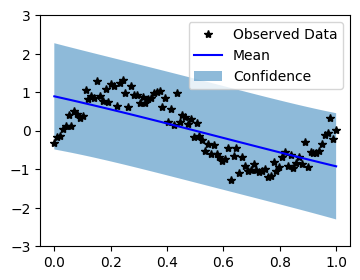

In [5]:
# initialize likelihood and model
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model = FirstQEPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

Clearly, the kernel doesn't perform well. This is due to the lack of a lengthscale parameter, which we will add next.

### Adding hyperparameters

Although the `FirstSincKernel` can be used for defining a model, it lacks a parameter that controls the correlation length. This lengthscale will be implemented as a hyperparameter. See also the [tutorial on hyperparamaters](https://qepytorch.readthedocs.io/en/stable/examples/00_Basic_Usage/Hyperparameters.html), for information on raw vs. actual parameters.

The parameter has to be registered, using the method `register_parameter()`, which `Kernel` inherits from `Module`. Similarly, we register constraints and priors.

In [6]:
# import positivity constraint
from qpytorch.constraints import Positive

class SincKernel(qpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True
    
    # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)
        
        # register the raw parameter
        self.register_parameter(
            name='raw_length', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )
        
        # set the parameter constraint to be positive, when nothing is specified
        if length_constraint is None:
            length_constraint = Positive()

        # register the constraint
        self.register_constraint("raw_length", length_constraint)
        
        # set the parameter prior, see
        # https://qepytorch.readthedocs.io/en/stable/module.html#qpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    # now set up the 'actual' paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.length)
        x2_ = x2.div(self.length)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

We can now define a new QEPModel, train it and make predictions:

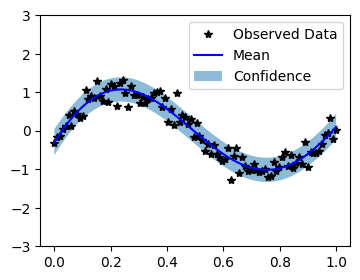

In [7]:
# Use the simplest form of QEP model, exact inference
class SincQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = SincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

# initialize the new model
model = SincQEPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

Because many kernels use a lengthscale, there is actually a simpler way to implement it, by using the `has_lengthscale` attribute from `Kernel`.

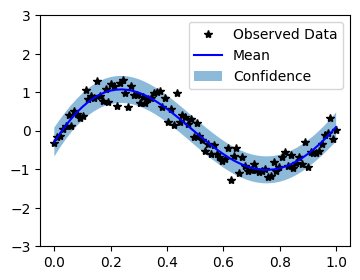

In [8]:
class SimpleSincKernel(qpytorch.kernels.Kernel):
    has_lengthscale = True
    
    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

# Use the simplest form of QEP model, exact inference
class SimpleSincQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = SimpleSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

# initialize the new model
model = SimpleSincQEPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)